# House Price Prediction Using Neural Nets (Keras/TensorFlow)

This notebook builds a neural network for house price prediction. It includes a cell that uses the correlation matrix to select the top five features (most correlated with SalePrice) to address high RMSE issues seen in other versions.

In [11]:
pip install tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load the Data

Replace the placeholder paths with the actual file paths for `train.csv` and `test.csv`.

In [13]:
# Replace these paths with the actual file paths
train_path = 'train.csv'
test_path = 'test.csv'

# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


## 2. Data Preprocessing

Fill missing values (numeric columns with the median and categorical columns with the mode) and convert categorical features into dummy variables. In the training data, drop the `Id` column and separate the target `SalePrice`.

In [14]:
def fill_missing_values(df):
    # Fill numeric columns with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop the Id column
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Separate target variable and features
y = train_df['SalePrice']
X = train_df.drop('SalePrice', axis=1)

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

Processed training features shape: (1000, 230)


/tmp/ipykernel_9834/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_9834/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## 2.1 Feature Selection

Use the correlation matrix to select the top five features that have the highest absolute correlation with the target variable (SalePrice).

In [15]:
# Compute correlation matrix only on numeric columns (including SalePrice)
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Get top 5 features with highest absolute correlation with SalePrice (excluding SalePrice itself)
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:6].index.tolist()
print('Top 5 features selected:', top_features)

# Then, update X to keep only these features
X = X[top_features]
print('X shape after feature selection:', X.shape)

Top 5 features selected: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X shape after feature selection: (1000, 5)


### 2.2 Train-Validation Split and Scaling

Split the training data (80% training, 20% validation) and scale the features.

In [16]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 5)
X_val_scaled shape: (200, 5)


## 3. Build and Train the Neural Network Model

Here we build a simple feed-forward neural network with two hidden layers (128 and 64 nodes) and dropout.

In [17]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-24 00:21:58.942551: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

### 3.1 Train the Model

Train the model while monitoring validation loss.

In [18]:
history = model.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val_scaled, y_val), 
                    verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 41166962688.0000 - val_loss: 34066571264.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41986330624.0000 - val_loss: 34064412672.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40432005120.0000 - val_loss: 34059536384.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41732640768.0000 - val_loss: 34050146304.0000
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39696846848.0000 - val_loss: 34033924096.0000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41790451712.0000 - val_loss: 34008817664.0000
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41656492032.0000 - val_loss: 33971886080.0000
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40709406720.0000 - val_loss: 33921341440.0000
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42022633472.0000 - val_loss: 33854044160.0000
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

### 3.2 Evaluate the Model

Predict on the validation set and compute the Root Mean Squared Error (RMSE).

In [19]:
y_val_pred = model.predict(X_val_scaled).flatten()
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print('Validation RMSE:', rmse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation RMSE: 62977.49388472044


## 4. Prepare the Test Data and Make Predictions

Process the test data in the same way, align the features, scale, and predict the house prices.

In [20]:
# Fill missing values in test data
test_df = fill_missing_values(test_df.copy())

# Save the test Ids and drop the 'Id' column
test_ids = test_df['Id']
test_df.drop('Id', axis=1, inplace=True)

# Convert categorical features to dummy variables
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test dataframe to training features (fill missing columns with 0)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Scale test features
test_scaled = scaler.transform(test_df)

# Predict on test data
test_predictions = model.predict(test_scaled).flatten()

print('Test predictions shape:', test_predictions.shape)

/tmp/ipykernel_9834/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_9834/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test predictions shape: (460,)


## 5. Save the Predictions

Save the predictions to a CSV file with columns **ID** (integer) and **SALEPRICE** (float).

In [21]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'SALEPRICE': test_predictions
})

# Save to CSV (replace with your desired output path)
predictions_csv_path = 'predictions_keras_v2.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print('Predictions saved to', predictions_csv_path)

Predictions saved to predictions_keras_v2.csv


## 6. (Optional) Plot Training History

Plot the training and validation loss over epochs.

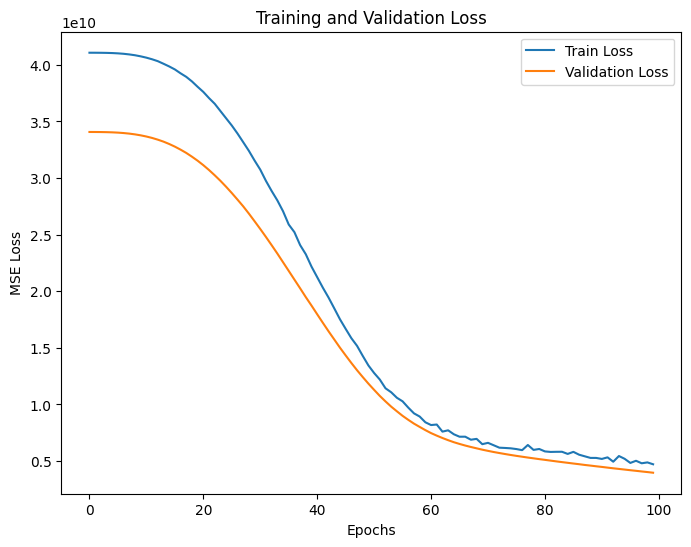

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()